<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install import_ipynb

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [10]:
import os, sys, warnings, itertools
import import_ipynb
import tarfile
import joblib
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     cross_val_predict, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             accuracy_score, precision_recall_curve, PrecisionRecallDisplay,
                             roc_auc_score, roc_curve)
from sklearn.multiclass import OneVsOneClassifier

In [11]:
warnings.filterwarnings("ignore")

In [12]:
%matplotlib inline

In [16]:
curr_path = os.path.abspath("./")

In [17]:
# from MachineLearningUtils import *

In [18]:
mnist = None
data_path = os.path.join(curr_path, "mnist.pkl")
if os.path.exists(data_path):
    mnist = joblib.load(data_path)
else:
    mnist = fetch_openml("mnist_784", version=1)
    joblib.dump(mnist, data_path)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [19]:
_X, _y = mnist.data, mnist.target
_y = _y.to_frame()
_y.columns = ['target']

In [20]:
X = _X.sample(n=1000, random_state=1)
y = _y.sample(n=1000, random_state=1)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [21]:
# display_df(X)

NameError: name 'display_df' is not defined

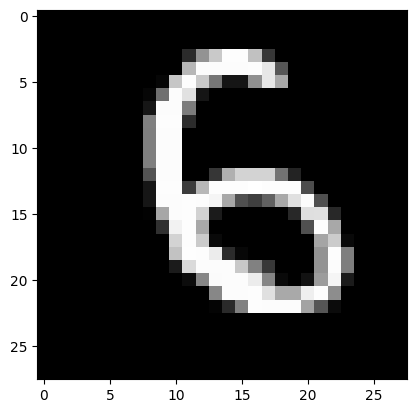

In [22]:
img = X.iloc[0].to_numpy().reshape(28, 28)
plt.imshow(img, cmap="gray")

In [24]:
y['target'] = y['target'].astype(np.uint8)
# display_df(y)

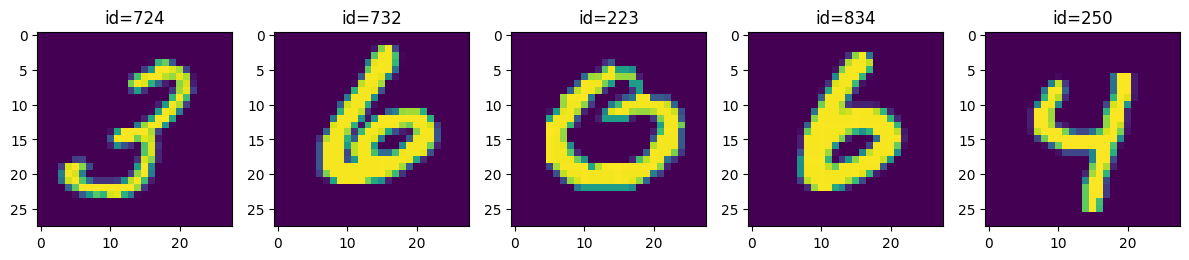

In [25]:
random_img = [random.randint(0, len(X)) for _ in range(5)]
num_rows = 1
num_cols = 5
fig = plt.figure(figsize=(12,14))
for _ in range(num_rows*num_cols):
    ax = fig.add_subplot(num_rows, num_cols, _+1)
    index = random_img[_]
    image = X.loc[index, :].to_numpy().reshape(28,28)
    ax.imshow(image)
    ax.set_title("id={}".format(index))
plt.tight_layout()

In [26]:
X_train, X_test, _y_train, _y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)

In [27]:
y_train = _y_train["target"].apply(lambda x: 1 if x==5 else 0)
y_test = _y_test["target"].apply(lambda x: 1 if x==5 else 0)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sgd_clf = SGDClassifier(random_state=42, loss="log_loss")
sgd_clf.fit(X_train_scaled, y_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94756554, 0.93632959, 0.94736842])

In [29]:
class NaiveModel(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
base_model = NaiveModel()
base_model.fit(X_train_scaled)
cross_val_score(base_model, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90262172, 0.89138577, 0.90977444])

In [30]:
pred_train = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
cm = confusion_matrix(y_train, pred_train)

In [32]:
# plot_conf_matrix(cm, classes=["Not Five", "Five"], normalize=False, title="Confusion matrix", cmap=plt.cm.Blues)

In [33]:
print("accuracy: {}".format(accuracy_score(y_train, pred_train)))
print("precision: {}".format(precision_score(y_train, pred_train)))
print("recall: {}".format(recall_score(y_train, pred_train)))
print("f1: {}".format(f1_score(y_train, pred_train)))

accuracy: 0.94375
precision: 0.7931034482758621
recall: 0.5822784810126582
f1: 0.6715328467153284


In [34]:
y_scores = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds = np.insert(thresholds, 0, thresholds[0])
df = pd.DataFrame({"precision": precisions, "recalls": recalls, "thresholds": thresholds})
df

,precision,recalls,thresholds
0,0.098750,1.000000,-5564.438238
1,0.098874,1.000000,-5564.438238
2,0.098997,1.000000,-4948.305091
3,0.099122,1.000000,-4498.955705
4,0.099246,1.000000,-4341.328791
...,...,...,...
796,1.000000,0.050633,884.592933
797,1.000000,0.037975,899.232854
798,1.000000,0.025316,900.618973
799,1.000000,0.012658,1067.182940


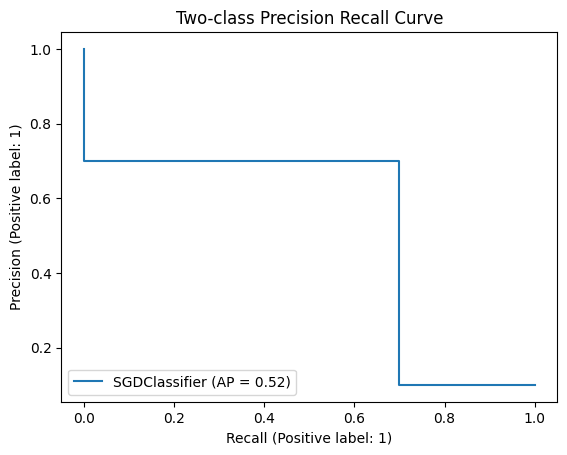

In [35]:
pos_rate_dispaly = PrecisionRecallDisplay.from_estimator(sgd_clf, X_test, y_test, name="SGDClassifier")
_ = pos_rate_dispaly.ax_.set_title("Two-class Precision Recall Curve")

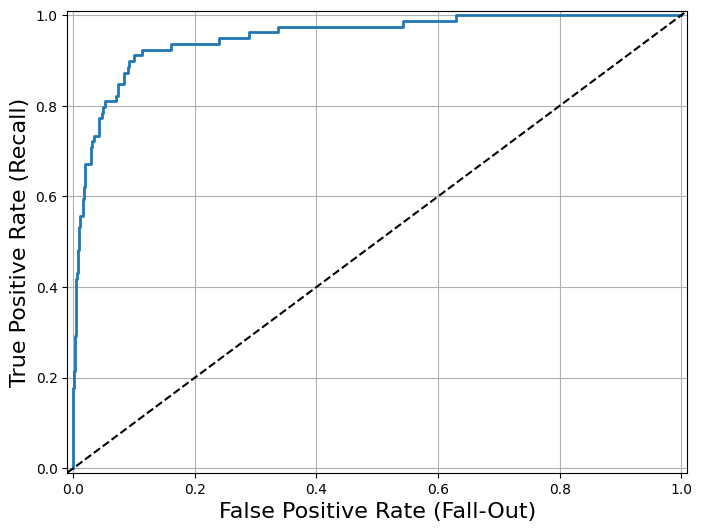

In [36]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([-0.01, 1.01], [-0.01, 1.01], "k--")
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [37]:
clf = SGDClassifier(random_state=42, loss="log_loss")
clf.fit(X_train_scaled, _y_train)
cross_val_score(clf, X_train_scaled, _y_train, cv=5, scoring="accuracy")
y_pred = cross_val_predict(clf, X_train_scaled, _y_train, cv=5)

In [38]:
first_digit = X_train_scaled[0,:]
first_digit_scores = clf.decision_function([first_digit])
first_digit_proba = clf.predict_proba([first_digit])
print("Classes: {}".format(clf.classes_))
print("Score for each class: {}".format(first_digit_scores[0]))
print("Probability for each class: {}".format(first_digit_proba[0]))
print("Class with the highest score: {}".format(np.argmax(first_digit_scores)))

Classes: [0 1 2 3 4 5 6 7 8 9]
Score for each class: [-1303.2061206  -1186.50407668 -2196.60972285 -3091.91794732
    52.97822408 -2314.99981643  -573.2529994  -1198.40440181
 -1731.34623884 -1517.22719661]
Probability for each class: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.00000000e+000 0.00000000e+000 1.09492816e-249 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Class with the highest score: 4


In [39]:
one_vs_one_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
one_vs_one_clf.fit(X_train_scaled, _y_train)
print("First digit is predicted as = {}".format(one_vs_one_clf.predict([first_digit])))
print("Number of estimators = {}".format(len(one_vs_one_clf.estimators_)))
print("First two estimators = {}".format(one_vs_one_clf.estimators_[:2]))

First digit is predicted as = [4]
Number of estimators = 45
First two estimators = (SGDClassifier(random_state=42), SGDClassifier(random_state=42))


In [40]:
X_train_scaled.shape

(800, 784)

In [41]:
clf.predict_proba([first_digit])

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        1.09492816e-249, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000]])

In [42]:
search_space = {
    "n_estimators": [200, 300, 500],
    "max_features": [300, 400, 500, 600],
    "max_depth": [10, 15, 20]
}
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=search_space, cv=3,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 15, 'max_features': 300, 'n_estimators': 300}
RandomForestClassifier(max_depth=15, max_features=300, n_estimators=300)


In [43]:
y_ = (y_train >=7)
y__ = (y_train % 2 == 1)
y_multi = np.c_[y_, y__]

In [44]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_multi)
fifth_digit = X_train_scaled[4,:]
clf.predict([fifth_digit])

array([[False, False]])

In [45]:
accuracy_score = cross_val_score(clf, X_train, y_multi, cv=3)
y_pred = cross_val_predict(clf, X_train, y_multi, cv=3)

In [46]:
print(y_pred)

[[False False]
 [False False]
 [False False]
 ...
 [False False]
 [False False]
 [False False]]
